## 1. Quá trình dự báo trên mô hình ARIMA

# Thêm thư viện

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pmdarima as pmd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

# Nạp dữ liệu từ file csv

In [2]:
df = pd.read_csv('xrp.csv')
df.pop('Currency')
df.pop('Volume')
df.pop('High')
df.pop('Low')
df.pop('Open')

df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date",inplace=True)
df_close = df['Close'].values.reshape(-1, 1)

df

,Close
Date,
2020-06-01,0.21090
2020-06-02,0.20317
2020-06-03,0.20411
2020-06-04,0.20438
2020-06-05,0.20282
...,...
2022-05-28,0.38637
2022-05-29,0.38910
2022-05-30,0.41859


# Chuẩn hóa dữ liệu

In [3]:
arima_sc = StandardScaler()

df_scaled = df.copy()
df_scaled['Close'] = arima_sc.fit_transform(df_close)
df_scaled

,Close
Date,
2020-06-01,-1.244092
2020-06-02,-1.265447
2020-06-03,-1.262850
2020-06-04,-1.262104
2020-06-05,-1.266414
...,...
2022-05-28,-0.759352
2022-05-29,-0.751810
2022-05-30,-0.670343


# Vẽ đồ thị

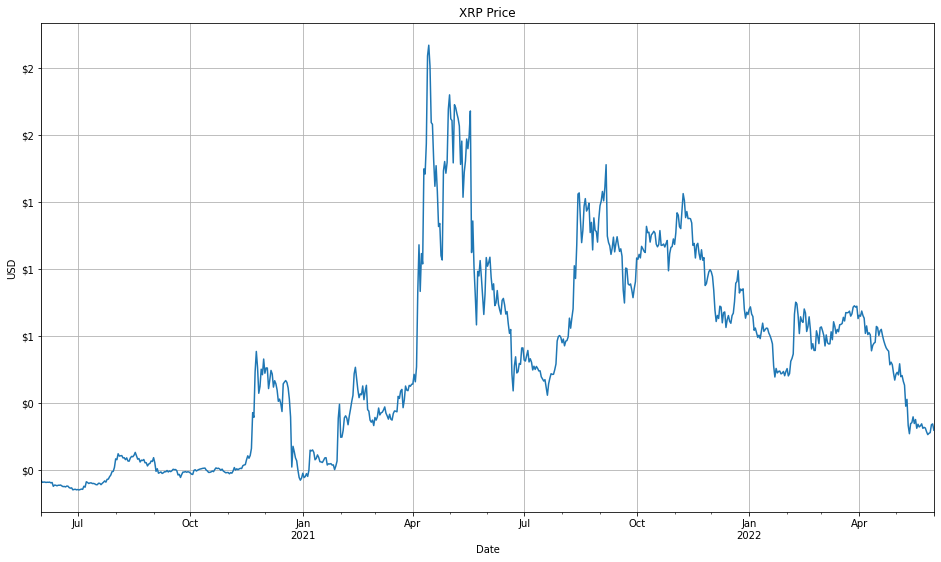

In [4]:
# Thư viện vẽ đồ thị
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = 'XRP Price'
ylabel = 'USD'
xlabel = 'Date'

ax = df['Close'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

# Tách dữ liệu thành tập train và test

In [5]:
train, test = df_scaled[:(int)(len(df_scaled) * 0.9)], df_scaled[(int)(len(df_scaled) * 0.9):]
index_test = df_scaled.index[(int)(len(df_scaled) * 0.9):]
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (584, 1)
test shape:  (147, 1)


# Hàm kiểm định chuỗi dừng

In [6]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")

# Kiểm định tính dừng của chuỗi

In [7]:
adf_test(train['Close'],'XRP Price')

Augmented Dickey-Fuller Test: XRP Price
ADF test statistic         -2.078090
p-value                     0.253416
Number of lags used        18.000000
Number of observations    565.000000
critical value (1%)        -3.441977
critical value (5%)        -2.866669
critical value (10%)       -2.569502
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng

# Tính sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng

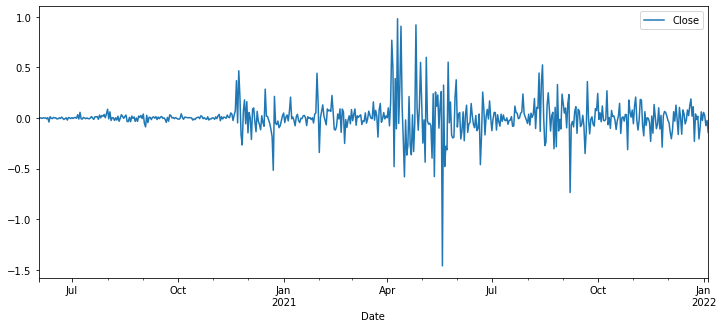

In [8]:
diff_1 = train.diff().dropna()
diff_1.plot(figsize=(12,5));

# Kiểm định tính dừng của chuỗi tại sai phân bậc 1

In [9]:
adf_test(diff_1, 'XRP Price First Difference')

Augmented Dickey-Fuller Test: XRP Price First Difference
ADF test statistic       -8.196913e+00
p-value                   7.406937e-13
Number of lags used       1.100000e+01
Number of observations    5.710000e+02
critical value (1%)      -3.441854e+00
critical value (5%)      -2.866615e+00
critical value (10%)     -2.569473e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1

In [10]:

def ArimaModel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              test="adf",
                              seasonal=False,
                              trace=True)
    return autoarima_model

In [11]:
arima_model = ArimaModel(train)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-424.174, Time=1.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-424.893, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-425.324, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-425.292, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-426.746, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-423.328, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.026 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  584
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 214.373
Date:                Sat, 25 Jun 2022   AIC                           -426.746
Time:                        18:15:58   BIC                           -422.378
Sample:                             0   HQIC                          -425.044
                                - 584                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0281      0.001     52.091      0.000       0.027       0.029
===================================================================================
Ljung-Box (L1) (Q):                   2.44   Jarque-Bera (JB):              6730.06
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               4.80   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Dự đoán trên tập test

In [12]:
pred = arima_model.predict(len(test))
pred


array([0.30389025, 0.30389025, 0.30389025, 0.30389025, 0.30389025,
       0.30389025, 0.30389025, 0.30389025, 0.30389025, 0.30389025,
       0.30389025, 0.30389025, 0.30389025, 0.30389025, 0.30389025,
       0.30389025, 0.30389025, 0.30389025, 0.30389025, 0.30389025,
       0.30389025, 0.30389025, 0.30389025, 0.30389025, 0.30389025,
       0.30389025, 0.30389025, 0.30389025, 0.30389025, 0.30389025,
       0.30389025, 0.30389025, 0.30389025, 0.30389025, 0.30389025,
       0.30389025, 0.30389025, 0.30389025, 0.30389025, 0.30389025,
       0.30389025, 0.30389025, 0.30389025, 0.30389025, 0.30389025,
       0.30389025, 0.30389025, 0.30389025, 0.30389025, 0.30389025,
       0.30389025, 0.30389025, 0.30389025, 0.30389025, 0.30389025,
       0.30389025, 0.30389025, 0.30389025, 0.30389025, 0.30389025,
       0.30389025, 0.30389025, 0.30389025, 0.30389025, 0.30389025,
       0.30389025, 0.30389025, 0.30389025, 0.30389025, 0.30389025,
       0.30389025, 0.30389025, 0.30389025, 0.30389025, 0.30389

# Biến đổi giá trị dự đoán và thực tế về miền giá trị ban đầu

In [13]:
inv_test = arima_sc.inverse_transform(test.values.reshape(-1, 1))
inv_pred = arima_sc.inverse_transform(column_or_1d(pred).reshape(-1, 1))

# Vẽ đồ thị cho tập test và kết quả dự đoán

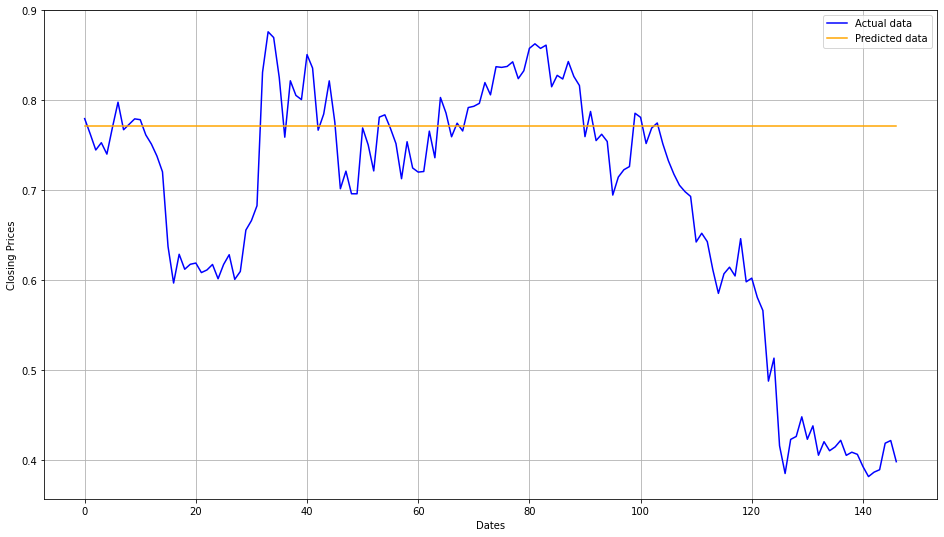

In [14]:
pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(inv_test, 'blue', label='Actual data')
plt.plot(inv_pred, 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [15]:
mae = mean_absolute_error(inv_test, inv_pred)
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_test, inv_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.11
MAPE: 22.06%
MSE: 0.03
RMSE: 0.16
R2: -0.37


# Tạo một DataFrame là 'df_pred' để lưu kết quả dự đoán trên mô hình ARIMA

In [16]:
df_pred = pd.DataFrame(index=index_test)
df_pred['Actual'] = inv_test
df_pred['ARIMA'] = inv_pred
df_pred['Error'] = inv_test - inv_pred
df_pred

,Actual,ARIMA,Error
Date,,,
2022-01-06,0.77960,0.77125,0.00835
2022-01-07,0.76260,0.77125,-0.00865
2022-01-08,0.74471,0.77125,-0.02654
2022-01-09,0.75283,0.77125,-0.01842
2022-01-10,0.74013,0.77125,-0.03112
...,...,...,...
2022-05-28,0.38637,0.77125,-0.38488
2022-05-29,0.38910,0.77125,-0.38215
2022-05-30,0.41859,0.77125,-0.35266


## 2. Quá trình dự đoán trên mô hình LSTM

# Tạo thêm một DataFrame để tiến hành dự đoán sai số trên mô hình LSTM

In [17]:
df_lstm = df_pred.copy()
df_lstm

,Actual,ARIMA,Error
Date,,,
2022-01-06,0.77960,0.77125,0.00835
2022-01-07,0.76260,0.77125,-0.00865
2022-01-08,0.74471,0.77125,-0.02654
2022-01-09,0.75283,0.77125,-0.01842
2022-01-10,0.74013,0.77125,-0.03112
...,...,...,...
2022-05-28,0.38637,0.77125,-0.38488
2022-05-29,0.38910,0.77125,-0.38215
2022-05-30,0.41859,0.77125,-0.35266


# Vẽ đồ thị thể hiện sai số

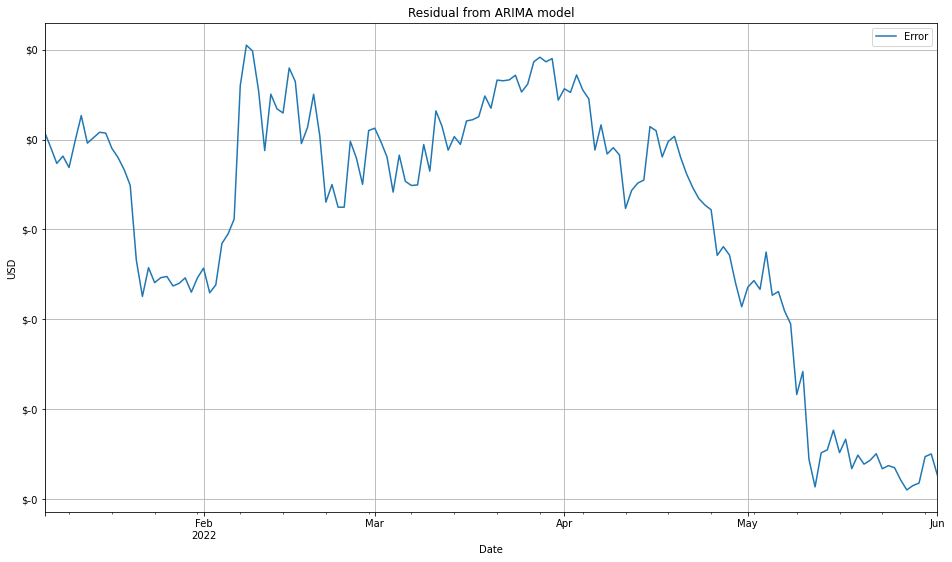

In [18]:
formatter = ticker.StrMethodFormatter('${x:,.0f}')

error = df_lstm[['Error']]
title = 'Residual from ARIMA model'
ylabel = 'USD'
xlabel = 'Date'

ax = error.plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [19]:
error = np.array(error)
error

array([[ 0.00835],
       [-0.00865],
       [-0.02654],
       [-0.01842],
       [-0.03112],
       [-0.00139],
       [ 0.02663],
       [-0.00401],
       [ 0.00198],
       [ 0.00809],
       [ 0.00718],
       [-0.00978],
       [-0.01989],
       [-0.03326],
       [-0.05081],
       [-0.13393],
       [-0.17451],
       [-0.14252],
       [-0.15917],
       [-0.15365],
       [-0.15229],
       [-0.16288],
       [-0.15997],
       [-0.15385],
       [-0.16977],
       [-0.15379],
       [-0.14302],
       [-0.17043],
       [-0.16164],
       [-0.11562],
       [-0.10508],
       [-0.08854],
       [ 0.05991],
       [ 0.10493],
       [ 0.09855],
       [ 0.05426],
       [-0.01229],
       [ 0.05046],
       [ 0.0342 ],
       [ 0.02952],
       [ 0.07958],
       [ 0.06457],
       [-0.00448],
       [ 0.01343],
       [ 0.05035],
       [ 0.00437],
       [-0.06963],
       [-0.05006],
       [-0.07523],
       [-0.07525],
       [-0.00199],
       [-0.02081],
       [-0.0

In [20]:
look_back = 3
x_total, y_total = [], []
for i in range(look_back, len(error)):
	x_total.append(error[i-look_back:i])
	y_total.append(error[i])
x_train = np.array(x_total[:len(error)])
y_train = np.array(y_total[:len(error)])

print("x_train",x_train.shape)
print("y_train",y_train.shape)


x_train (144, 3, 1)
y_train (144, 1)


In [21]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(x_train, y_train, epochs=300, verbose=1)
model.save("xrp_9_1.h5")

Epoch 1/300
5/5 [==============================] - 3s 6ms/step - loss: 0.0259
Epoch 2/300
5/5 [==============================] - 0s 6ms/step - loss: 0.0225
Epoch 3/300
5/5 [==============================] - 0s 6ms/step - loss: 0.0201
Epoch 4/300
5/5 [==============================] - 0s 6ms/step - loss: 0.0174
Epoch 5/300
5/5 [==============================] - 0s 6ms/step - loss: 0.0158
Epoch 6/300
5/5 [==============================] - 0s 6ms/step - loss: 0.0137
Epoch 7/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0115
Epoch 8/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0092
Epoch 9/300
5/5 [==============================] - 0s 6ms/step - loss: 0.0067
Epoch 10/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0044
Epoch 11/300
5/5 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 12/300
5/5 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 13/300
5/5 [==============================] - 0s 7ms/st

In [22]:
model = load_model("xrp_9_1.h5")
error_pred = model.predict(x_train)
error_pred

5/5 [==============================] - 1s 4ms/step


array([[-2.6677940e-02],
       [-2.1536136e-02],
       [-3.1230779e-02],
       [-7.8538842e-03],
       [ 1.7449606e-02],
       [-5.6918934e-03],
       [-3.0055270e-03],
       [ 2.3263991e-03],
       [ 2.0185038e-03],
       [-1.1818590e-02],
       [-2.1383077e-02],
       [-3.3105321e-02],
       [-4.8521310e-02],
       [-1.2004715e-01],
       [-1.6857508e-01],
       [-1.4966194e-01],
       [-1.6077700e-01],
       [-1.5723944e-01],
       [-1.5567541e-01],
       [-1.6498622e-01],
       [-1.6428301e-01],
       [-1.5846795e-01],
       [-1.7193004e-01],
       [-1.6000636e-01],
       [-1.4746040e-01],
       [-1.7055014e-01],
       [-1.6694990e-01],
       [-1.2324139e-01],
       [-1.0672700e-01],
       [-8.8475004e-02],
       [ 4.1976489e-02],
       [ 8.4272631e-02],
       [ 8.0066688e-02],
       [ 4.6134442e-02],
       [-9.0991072e-03],
       [ 3.6003612e-02],
       [ 2.6908070e-02],
       [ 2.2314951e-02],
       [ 6.1948903e-02],
       [ 5.2770376e-02],


In [23]:
df_lstm = df_lstm.copy().head(len(error_pred))
df_lstm['Error Prediction'] = error_pred
df_lstm

,Actual,ARIMA,Error,Error Prediction
Date,,,,
2022-01-06,0.77960,0.77125,0.00835,-0.026678
2022-01-07,0.76260,0.77125,-0.00865,-0.021536
2022-01-08,0.74471,0.77125,-0.02654,-0.031231
2022-01-09,0.75283,0.77125,-0.01842,-0.007854
2022-01-10,0.74013,0.77125,-0.03112,0.017450
...,...,...,...,...
2022-05-25,0.40620,0.77125,-0.36505,-0.395112
2022-05-26,0.39265,0.77125,-0.37860,-0.390828
2022-05-27,0.38149,0.77125,-0.38976,-0.388383


In [24]:
df_lstm['ARIMA_LSTM'] = df_lstm['ARIMA'] + df_lstm['Error Prediction']
df_lstm

,Actual,ARIMA,Error,Error Prediction,ARIMA_LSTM
Date,,,,,
2022-01-06,0.77960,0.77125,0.00835,-0.026678,0.744572
2022-01-07,0.76260,0.77125,-0.00865,-0.021536,0.749714
2022-01-08,0.74471,0.77125,-0.02654,-0.031231,0.740019
2022-01-09,0.75283,0.77125,-0.01842,-0.007854,0.763396
2022-01-10,0.74013,0.77125,-0.03112,0.017450,0.788700
...,...,...,...,...,...
2022-05-25,0.40620,0.77125,-0.36505,-0.395112,0.376138
2022-05-26,0.39265,0.77125,-0.37860,-0.390828,0.380422
2022-05-27,0.38149,0.77125,-0.38976,-0.388383,0.382867


# Vẽ đồ thị

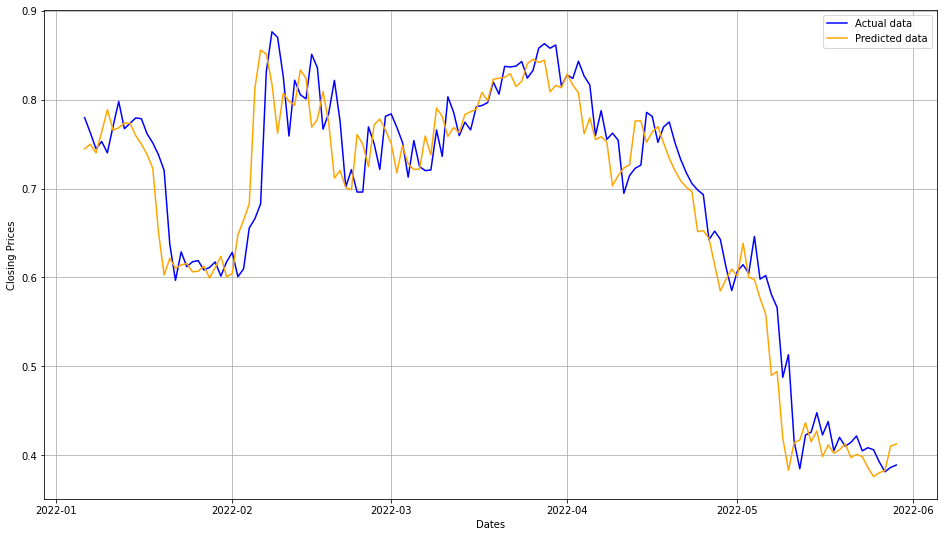

In [25]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_lstm['Actual'], 'blue', label='Actual data')
plt.plot(df_lstm['ARIMA_LSTM'], 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [26]:
mae = mean_absolute_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
mape = mean_absolute_percentage_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
mse = mean_squared_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
rmse = np.sqrt(mse)
r2 = r2_score(df_lstm.Actual, df_lstm.ARIMA_LSTM)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.03
MAPE: 4.43%
MSE: 0.00
RMSE: 0.04
R2: 0.91


# Lấy 3 ngày cuối ra để dự báo

In [27]:
forecast = df_lstm['Error'].tail(3)
forecast

Date
2022-05-27   -0.38976
2022-05-28   -0.38488
2022-05-29   -0.38215
Name: Error, dtype: float64

# Đưa về ma trận

In [28]:
dataX = []
for i in range(len(forecast)):
    a=forecast[i]
    dataX.append(a)
dataX = np.array(dataX).reshape(1,-1,1)
dataX

array([[[-0.38976],
        [-0.38488],
        [-0.38215]]])

In [29]:
y_forecast= model.predict(dataX).reshape(1,)
y_forecast

1/1 [==============================] - 0s 32ms/step


array([-0.38838303], dtype=float32)

# So sánh kết quả dự đoán với giá trị thực

In [30]:
y_arima = df_pred.copy()
y_arima = y_arima.tail(4).head(1)
y_arima

,Actual,ARIMA,Error
Date,,,
2022-05-29,0.3891,0.77125,-0.38215


In [31]:
y_arima['Final_LSTM'] = y_arima.ARIMA + y_forecast
y_arima

,Actual,ARIMA,Error,Final_LSTM
Date,,,,
2022-05-29,0.3891,0.77125,-0.38215,0.382867


# Ghi ra file csv

In [32]:
df.to_csv("xrp_processed_data_9_1.csv")
df_scaled.to_csv("xrp_scaled_data_9_1.csv")
df_pred.to_csv("xrp_ARIMA-PRED_9_1.csv")
df_lstm.to_csv("xrp_LSTM_PRED_9_1.csv")
y_arima.to_csv("xrp_Forecast_9_1.csv")